In [1]:
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataroot = 'data/airfoil_interp.npy'
data = np.load(dataroot)

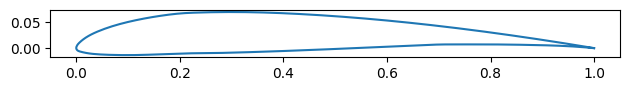

In [2]:
fig, axs = plt.subplots(1, 1)
axs.plot(data[0,:,0], data[0,:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()


In [3]:
sample = np.load('sample.npy')
# sample = np.squeeze(sample, axis=1)

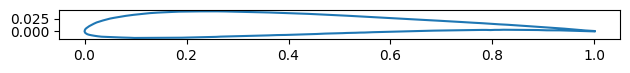

In [4]:
i = 1
fig, axs = plt.subplots(1, 1)
axs.plot(sample[i,:,0], sample[i,:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

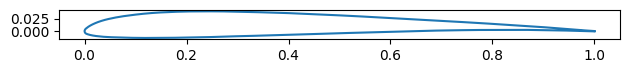

In [5]:
xhat, yhat = savgol_filter((sample[i,:,0], sample[i,:,1]), 10, 3)
fig, axs = plt.subplots(1, 1)
axs.plot(xhat, yhat)
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

In [6]:
abs(yhat[:128] - np.flip(yhat[-128:])).max()

0.05101413

In [51]:
import numpy as np
from xfoil import XFoil
from xfoil.model import Airfoil
import matplotlib.pyplot as plt
from simulation import detect_intersect, evaluate, Normalize, derotate
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

In [52]:
import numpy as np
from scipy.interpolate import splev, splprep, interp1d
from scipy.integrate import cumtrapz

def interpolate(Q, N, k, D=20, resolution=1000):
    ''' Interpolate N points whose concentration is based on curvature. '''
    res, fp, ier, msg = splprep(Q.T, u=None, k=k, s=1e-6, per=0, full_output=1)
    tck, u = res
    uu = np.linspace(u.min(), u.max(), resolution)
    x, y = splev(uu, tck, der=0)
    dx, dy = splev(uu, tck, der=1)
    ddx, ddy = splev(uu, tck, der=2)
    cv = np.abs(ddx*dy - dx*ddy)/(dx*dx + dy*dy)**1.5 + D
    cv_int = cumtrapz(cv, uu, initial=0)
    fcv = interp1d(cv_int, uu)
    cv_int_samples = np.linspace(0, cv_int.max(), N)
    u_new = fcv(cv_int_samples)
    x_new, y_new = splev(u_new, tck, der=0)
    xy_new = np.vstack((x_new, y_new)).T
    return xy_new

In [53]:
airfoil1D = np.loadtxt('results/airfoil1D.dat')
airfoil = np.loadtxt('results/airfoil.dat')

In [121]:
def delete_intersect(samples):
    indexs = []
    for i in range(samples.shape[0]):
        xhat, yhat = savgol_filter((samples[i,:,0], samples[i,:,1]), 10, 3)
        samples[i,:,0] = xhat
        samples[i,:,1] = yhat
        af = samples[i,:,:]
        if detect_intersect(af):
            indexs.append(i)
    for i in indexs:
        xhat, yhat = savgol_filter((samples[i,:,0], samples[i,:,1]), 10, 3)
        samples[i,:,0] = xhat
        samples[i,:,1] = yhat
        af = samples[i,:,:]
        point = 1.0
        while detect_intersect(af):
            indexs = []
            for index in range(af.shape[0]):
                if af[index,0] > point:
                    indexs.append(index)
            af = np.delete(af, indexs, axis=0)
            point -= 0.01
        af = interpolate(af, 256, 3)
        af = Normalize(af)
        samples[i,:,:] = af
    return samples

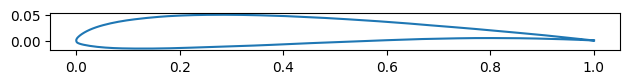

[]

In [122]:
samples = np.load('sample.npy')
samples = delete_intersect(samples)

fig, axs = plt.subplots(1, 1)
xhat, yhat = savgol_filter((samples[58,:,0], samples[58,:,1]), 10, 3)
samples[58,:,0] = xhat
samples[58,:,1] = yhat
axs.plot(samples[58,:,0], samples[58,:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

detect_intersect(samples[58,:,:])

intersect = []
for i in range(samples.shape[0]):
    xhat, yhat = savgol_filter((samples[i,:,0], samples[i,:,1]), 10, 3)
    samples[i,:,0] = xhat
    samples[i,:,1] = yhat
    af = samples[i,:,:]
    if detect_intersect(af):
        intersect.append(i)
intersect

In [109]:
intersect = []
for i in range(samples.shape[0]):
    xhat, yhat = savgol_filter((samples[i,:,0], samples[i,:,1]), 5, 3)
    samples[i,:,0] = xhat
    samples[i,:,1] = yhat
    af = samples[i,:,:]
    if detect_intersect(af):
        intersect.append(i)
intersect

[]

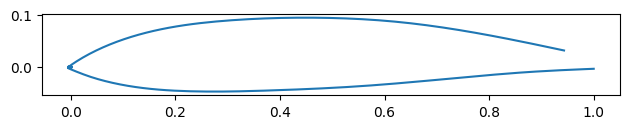

In [95]:
fig, axs = plt.subplots(1, 1)
xhat, yhat = savgol_filter((samples[4,:,0], samples[4,:,1]), 5, 3)
samples[4,:,0] = xhat
samples[4,:,1] = yhat
axs.plot(samples[4,:,0], samples[4,:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

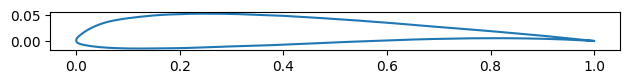

In [11]:
fig, axs = plt.subplots(1, 1)
axs.plot(airfoil1D[:,0], airfoil1D[:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

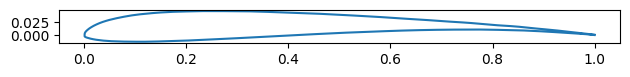

In [ ]:
fig, axs = plt.subplots(1, 1)
axs.plot(airfoil[:,0], airfoil[:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

In [ ]:
def derotate(airfoil):
    ptail = 0.5 * (airfoil[0,:]+airfoil[-1,:])
    ptails = np.expand_dims(ptail, axis=0)
    ptails = np.repeat(ptails, 256, axis=0)
    i = np.linalg.norm(airfoil - ptails, axis=1).argmax()
    phead = airfoil[i,:]
    theta = np.arctan2(-(airfoil[i,1] - ptail[1]), -(airfoil[i,0] - ptail[0]))
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    airfoil_R = airfoil
    airfoil_R -= np.repeat(np.expand_dims(phead, axis=0), 256, axis=0)
    airfoil_R = np.matmul(airfoil_R, R)
    return airfoil_R

def Normalize(airfoil):
    r = np.maximum(airfoil[0,0], airfoil[-1,0])
    r = float(1.0/r)
    return airfoil * r

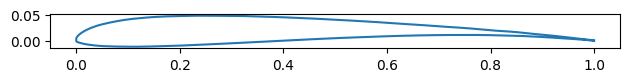

In [ ]:
airfoil_R = derotate(airfoil)
airfoil_R = Normalize(airfoil_R)
fig, axs = plt.subplots(1, 1)
axs.plot(airfoil_R[:,0], airfoil_R[:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

In [ ]:
ptail = 0.5 * (airfoil_R[0,:]+airfoil_R[-1,:])
ptails = np.expand_dims(ptail, axis=0)
ptails = np.repeat(ptails, 256, axis=0)
i = np.linalg.norm(airfoil_R - ptails, axis=1).argmax()
phead = airfoil_R[i,:]
theta = np.arctan2(-(airfoil_R[i,1] - ptail[1]), -(airfoil_R[i,0] - ptail[0]))
phead

array([0., 0.])

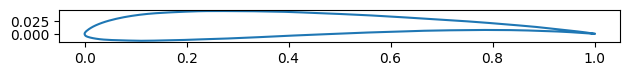

In [ ]:
airfoil_R1D = derotate(airfoil1D)
airfoil_R1D = Normalize(airfoil_R1D)
fig, axs = plt.subplots(1, 1)
axs.plot(airfoil_R1D[:,0], airfoil_R1D[:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()